<a href="https://colab.research.google.com/github/MasaAsami/modified_DMLDiD_RCS/blob/main/notebooks/Reproduction_of_DMLDiD_RCS_with_SIMDATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!git clone https://github.com/MasaAsami/modified_DMLDiD_RCS.git
#cd modified_DMLDiD_RCS
#cd notebooks

In [2]:
# title import pkg
import warnings

warnings.filterwarnings("ignore")

import sys
import os


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import (
    LogisticRegressionCV,
    LassoCV,
    Lasso,
    LogisticRegression,
)


sys.path.append(os.path.abspath("../"))
from dmldid.model_rcs import DMLDiD_RCS

from dmldid.simdata_genrater import generate_simdata_rcs, generate_simdata_rcs_fixX

# Verification with simulation data
## simulation data
-  repeated cross-section data
- true ATT := 3
- dim(X) := 10
- N = 500

In [3]:
df_rcs = generate_simdata_rcs_fixX(
    base_seed=1, N=500, Xcolumns_cnt=10, nonnull_x_cnt=3, true_att=3
)
df_rcs.head()

,unit_id,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,latent_group,latent_ps,D,Y,T
0,0,-9.158183,1.161933,-4.532897,-0.930350,-1.603513,-1.724936,12.394700,7.070890,-10.452273,-4.790106,0,0.9,0,39.009103,0
1,1,-3.828637,0.838513,-8.531369,-7.304513,3.296022,-1.154199,-8.826942,6.440126,0.611044,10.063201,0,0.9,0,46.126856,1
2,2,-6.398642,0.564814,-0.966379,3.116474,-2.249222,-13.965425,-4.981031,-1.365401,2.937855,6.069565,0,0.9,1,57.573361,0
3,3,-4.874784,0.839733,-8.429688,6.560939,7.819512,9.687644,-5.283466,5.637754,9.863194,-6.501527,0,0.9,0,40.649214,0
4,4,-4.776949,0.900822,-4.429587,1.324093,-5.327807,1.831660,-1.674586,-4.909411,-3.382856,9.890967,0,0.9,1,47.394932,0


## naive DiD

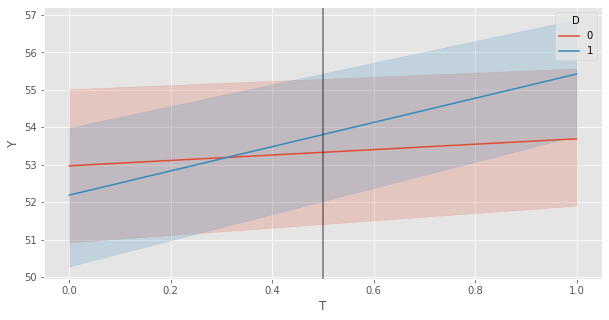

In [4]:
fig, ax = plt.subplots(1, 1, sharex="col", sharey="row", figsize=(10, 5))
sns.lineplot(x="T", y="Y", hue="D", data=df_rcs, ax=ax)
ax.axvline(x=0.5, alpha=0.5, color="black")
plt.show()

In [5]:
y_col = "Y"
d_col = "D"
t_col = "T"
X_cols = [col for col in df_rcs.columns if "x" in col]

# My solution:
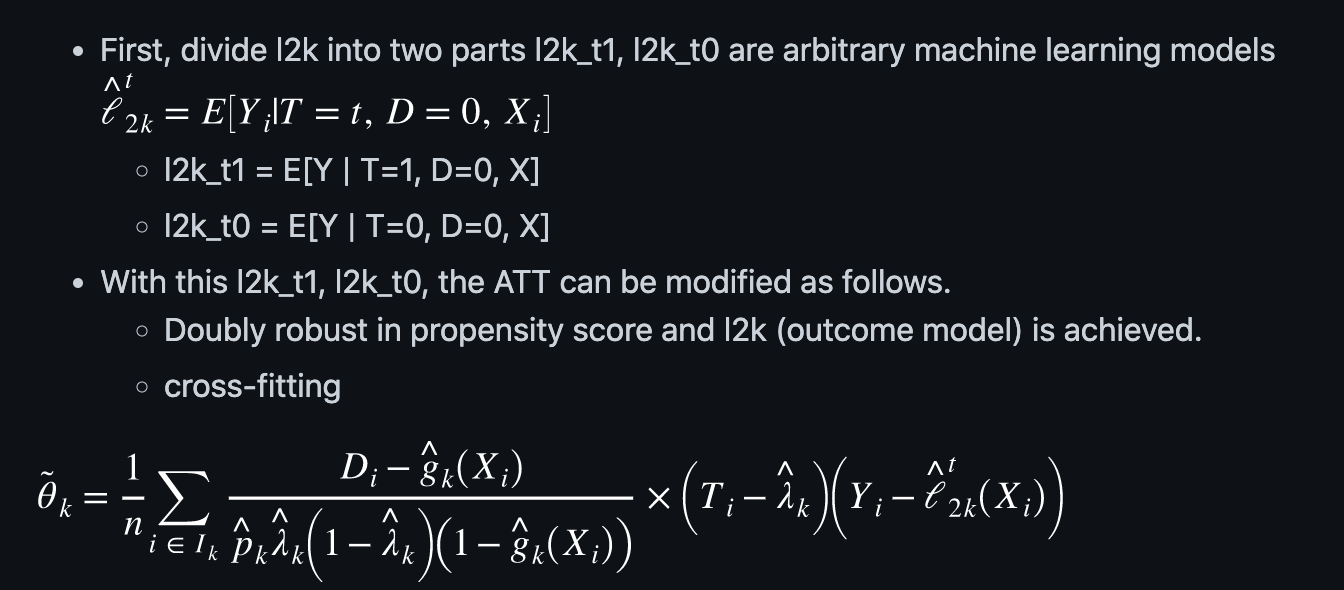

- linear_dmldid employs LogisticRegressionCV and LassoCV for l2k
- lgbm_dmldid employs LGBM for l2k

In [6]:
linear_dmldid = DMLDiD_RCS()

lgbm_dmldid = DMLDiD_RCS(
    d_model=LGBMClassifier(random_state=0),
    l2k_model=LGBMRegressor(random_state=0),
)

In [7]:
linear_dmldid.fit(
    df_rcs,
    y_col,
    d_col,
    t_col,
    X_cols,
    dmldid=True,
    sim_cnt=100,
    base_random_seed=0,
    progress_plot=True,
    d_model_t0_only=True,
)
algo_modified_bar = linear_dmldid.sim_att_result()

99. att :  2.957512545235049


In [8]:
lgbm_dmldid.fit(
    df_rcs,
    y_col,
    d_col,
    t_col,
    X_cols,
    dmldid=True,
    sim_cnt=100,
    base_random_seed=0,
    progress_plot=True,
    d_model_t0_only=True
)
algo_modified_bar_lgbm = lgbm_dmldid.sim_att_result()

99. att :  2.2337362713653013


# Chang(2020)
- The following R code is from [Chang (2020)](https://github.com/NengChiehChang/Diff-in-Diff/blob/master/Table%202/DMLML.R).
- DMLML:Unchanged except for the addition of a progress bar
- fixed_DMLML: The concept of Chang(2020) is unchanged. However, an obvious implementation error was corrected.

In [9]:
Y = df_rcs[X_cols + [y_col , d_col , t_col]].dropna().reset_index(drop=True)[[y_col]].to_numpy()
D = df_rcs[X_cols + [y_col , d_col , t_col]].dropna().reset_index(drop=True)[[d_col]].to_numpy()
T = df_rcs[X_cols + [y_col , d_col , t_col]].dropna().reset_index(drop=True)[[t_col]].to_numpy()
X = df_rcs[X_cols + [y_col , d_col , t_col]].dropna().reset_index(drop=True)[X_cols].astype(float).to_numpy()

In [10]:
%load_ext rpy2.ipython

In [11]:
%R  -i Y
%R  -i D
%R  -i T
%R  -i X

In [12]:
%%R
library(glmnet)

p=X
DMLML=function(Y,D,p,T){
  N=length(Y)
  B=100
  set.seed(123)
  random=sample(1:1000,B)
  
  thetabar=c(0)
  pb <- txtProgressBar(min = 1, max = B, style = 3)
  for (l in 1:B){
    k=2
    setTxtProgressBar(pb, l)
    samplesplit=function(k,N){
      c1=1:N
      smp_size <- floor((1/k) * length(c1))
      
      ## set the seed to make your partition reproducible
      set.seed(random[l])
      train_ind <- sample(seq_len(length(c1)), size = smp_size)
      
      k1 <- c1[train_ind]
      k2 <- c1[-train_ind]
      return(rbind(k1,k2))
    }
    K=samplesplit(k,N)
    
    thetaDML=c(0)
    
    for (q in 1:k){
      ##Trimming
      set.seed(333)
      CV=cv.glmnet(p[-K[q,],],D[-K[q,]],family="binomial",alpha=1)
      fit=glmnet(p[-K[q,],],D[-K[q,]],family="binomial",alpha=1,lambda=CV$lambda.1se)
      beta1hat=fit$beta
      beta1hat <- as.numeric(as.character(beta1hat))
      
      ghat=1/(1+exp(-p[K[q,],]%*%beta1hat))
      #ghat = predict(fit, p[K[q,],], type="response")
      
      index1=K[q,][which(ghat<0.97 & ghat>0.03)]
      
      ##Estimation
      ghat=1/(1+exp(-p[index1,]%*%beta1hat))
      #ghat = predict(fit, p[index1,], type="response")
      
      lambda=mean(T[-K[q,]])
      
      index=which(D[-K[q,]]==0)
      YY=Y[-K[q,]]
      YY=YY[index]
      TT=T[-K[q,]]
      TT=TT[index]
      XX=p[-K[q,],]
      XX=XX[index,]
      
      set.seed(333)
      CV=cv.glmnet(XX,(TT-lambda)*YY,family="gaussian",alpha=1)
      fit=glmnet(XX,(TT-lambda)*YY,family="gaussian",alpha=1,lambda=CV$lambda.1se)
      
      beta2hat=fit$beta
      beta2hat <- as.numeric(as.character(beta2hat))
      
      ellhat2=p[index1,]%*%beta2hat
      #ellhat2 = predict(fit,p[index1,])
      
      
      s=((T[index1]-lambda)*Y[index1]-ellhat2)*(D[index1]-ghat)/(1-ghat)/(lambda*(1-lambda))/mean(D[index1])
      s=s[which(s<abs(min(s)))]
      
      thetaDML[q]=mean(s)
      
    }
    thetabar[l]=mean(thetaDML)
  }
  finaltheta=mean(thetabar)
  return(thetabar)
}

fixed_DMLML=function(Y,D,p,T){
  N=length(Y)
  B=100
  set.seed(123)
  random=sample(1:1000,B)
  
  thetabar=c(0)
  pb <- txtProgressBar(min = 1, max = B, style = 3)
  for (l in 1:B){
    k=2
    setTxtProgressBar(pb, l)
    samplesplit=function(k,N){
      c1=1:N
      smp_size <- floor((1/k) * length(c1))
      
      ## set the seed to make your partition reproducible
      set.seed(random[l])
      train_ind <- sample(seq_len(length(c1)), size = smp_size)
      
      k1 <- c1[train_ind]
      k2 <- c1[-train_ind]
      return(rbind(k1,k2))
    }
    K=samplesplit(k,N)
    
    thetaDML=c(0)
    
    for (q in 1:k){
      ##Trimming
      set.seed(333)
      CV=cv.glmnet(p[-K[q,],],D[-K[q,]],family="binomial",alpha=1)
      fit=glmnet(p[-K[q,],],D[-K[q,]],family="binomial",alpha=1,lambda=CV$lambda.1se)
      beta1hat=fit$beta
      beta1hat <- as.numeric(as.character(beta1hat))
      
      #ghat=1/(1+exp(-p[K[q,],]%*%beta1hat))
      ghat = predict(fit, p[K[q,],], type="response")
      
      index1=K[q,][which(ghat<0.97 & ghat>0.03)]
      
      ##Estimation
      #ghat=1/(1+exp(-p[index1,]%*%beta1hat))
      ghat = predict(fit, p[index1,], type="response")
      
      lambda=mean(T[-K[q,]])
      
      index=which(D[-K[q,]]==0)
      YY=Y[-K[q,]]
      YY=YY[index]
      TT=T[-K[q,]]
      TT=TT[index]
      XX=p[-K[q,],]
      XX=XX[index,]
      
      set.seed(333)
      CV=cv.glmnet(XX,(TT-lambda)*YY,family="gaussian",alpha=1)
      fit=glmnet(XX,(TT-lambda)*YY,family="gaussian",alpha=1,lambda=CV$lambda.1se)
      
      beta2hat=fit$beta
      beta2hat <- as.numeric(as.character(beta2hat))
      
      #ellhat2=p[index1,]%*%beta2hat
      ellhat2 = predict(fit,p[index1,])
      
      
      s=((T[index1]-lambda)*Y[index1]-ellhat2)*(D[index1]-ghat)/(1-ghat)/(lambda*(1-lambda))/mean(D[index1])
      # s=s[which(s
      
      thetaDML[q]=mean(s)
      
    }
    thetabar[l]=mean(thetaDML)
  }
  finaltheta=mean(thetabar)
  return(thetabar)
}
r_result = DMLML(Y,D,p,T)
fixed_r_result = fixed_DMLML(Y,D,p,T)

R[write to console]:  要求されたパッケージ Matrix をロード中です 

R[write to console]: Loaded glmnet 4.1-3



  |======================================================================| 100%

In [13]:
%R -o r_result
%R -o fixed_r_result

# Result :  modified DMLDiD  > original
- The modified model proposed in this notebook is more successful in reducing bias

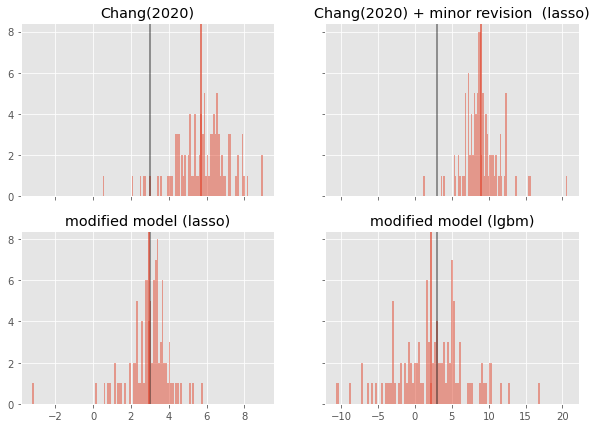

In [14]:
_label = [
    "Chang(2020)",
    "Chang(2020) + minor revision  (lasso)",
    "modified model (lasso)",
    "modified model (lgbm)",
]
result_df = pd.DataFrame(
    {
        "original_bar": r_result,
        "few_fixed_bar": fixed_r_result,
        "algo_modified_bar": algo_modified_bar,
        "algo_modified_bar_lgbm": algo_modified_bar_lgbm,
    }
)
fig, ax = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(10, 7))
ax = ax.ravel()
for i, _col in enumerate(result_df.columns):
    ax[i].hist(result_df[_col], bins=100, alpha=0.5)
    # ax[i].set_xlim(0,5)
    ax[i].set_title(_label[i])
    ax[i].axvline(x=3, alpha=0.5, color="black")
    ax[i].axvline(x=result_df[_col].mean(), alpha=0.9)
plt.show()

In [15]:
print("ture ATT : 3")
result_df.describe().T

ture ATT : 3


,count,mean,std,min,25%,50%,75%,max
original_bar,100.0,5.728571,1.449711,0.514366,4.901923,5.855250,6.564527,8.965748
few_fixed_bar,100.0,8.942929,2.517445,1.135911,7.622044,8.693643,9.903988,20.628340
algo_modified_bar,100.0,2.958169,1.132961,-3.219952,2.597367,3.067935,3.530150,5.792103
algo_modified_bar_lgbm,100.0,2.227825,4.756312,-10.649302,-0.747358,2.630222,5.048391,17.025621


As shown in the above results, the modified DMLDiD is more successful in reducing bias

In [16]:
print("Done")

Done
